# Advanced Lane Finding Project

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
- Video pipeline

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# Camera calibration [01-Camera Calibration](./01-Camera Calibration.ipynb)

In [4]:
# Loading camera calibration
cameraCalibration = pickle.load( open('./calibration.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

# Apply a distortion correction to raw images.

In [5]:
# Load test images.
testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
                      glob.glob('./test_images/*.jpg')))


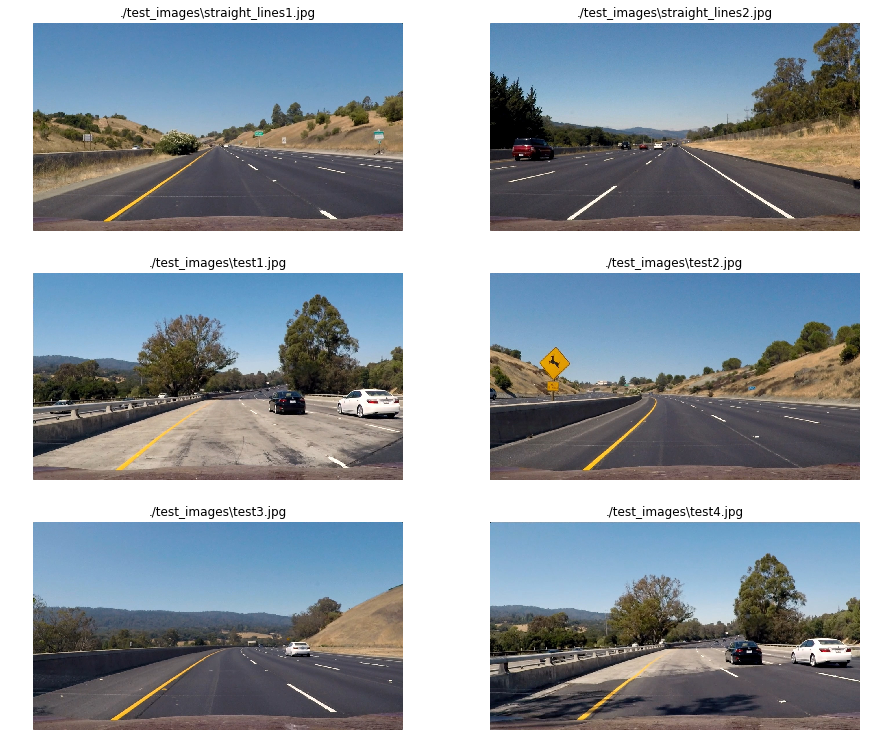

In [6]:
def showImages(images, cols = 4, rows = 5, figsize=(15,10), cmap = None):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.set_title(imagePathName)
            ax.axis('off')
        
showImages(list(map(lambda img: (img[0], cv2.cvtColor(img[1], cv2.COLOR_BGR2RGB)),testImages)), 2, 3, (15, 13))

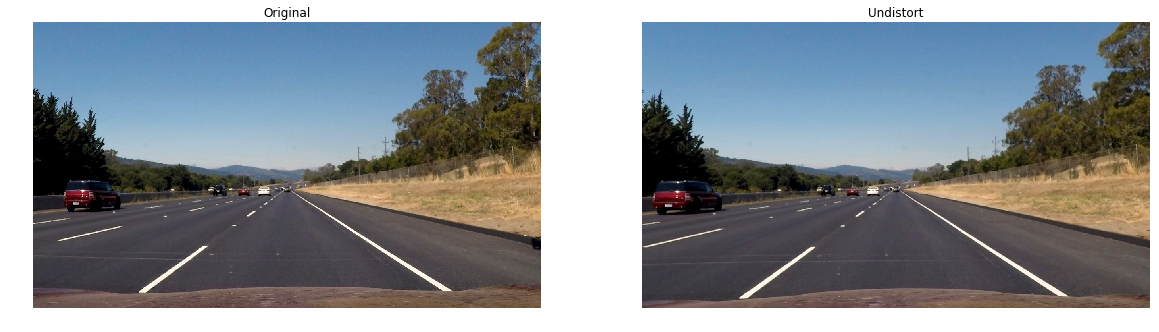

In [7]:
def imageSideBySide(leftImg, leftTitle, rightImg, rightTitle, figsize=(20,10) , leftCmap=None, rightCmap=None):
    """
    Display the images `leftImg` and `rightImg` side by side with image titles.
    """
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    if leftCmap == None:
        axes[0].imshow(leftImg)
    else:
        axes[0].imshow(leftImg, cmap=leftCmap)
    axes[0].set_title(leftTitle)
    axes[0].axis('off')
    if rightCmap == None:
        axes[1].imshow(rightImg)
    else:
        axes[1].imshow(rightImg, cmap=rightCmap)
    axes[1].set_title(rightTitle)
    axes[1].axis('off')
    
                
index = 1
original = testImages[index][1]
imageSideBySide(
    cv2.cvtColor(original, cv2.COLOR_BGR2RGB), 'Original',
    cv2.cvtColor(cv2.undistort(original, mtx, dist, None, mtx), cv2.COLOR_BGR2RGB), 'Undistort'
)

# Use color transforms, gradients, etc., to create a thresholded binary image.
for exploration details and orther visualizations [visit this notebook](02-Color%20Transform%20and%20Gradients%20Threshold.ipynb)

In [8]:
def undistortAndHLS(image, mtx=mtx, dist=dist):
    """
    Undistort the image with `mtx`, `dist` and convert it to HLS.
    """
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)

hlsOriginal = undistortAndHLS(original)

## Color space

In [9]:
useSChannel = lambda img: undistortAndHLS(img)[:,:,2]

## Sobel

In [10]:
def threshIt(img, thresh_min, thresh_max):
    """
    Applies a threshold to the `img` using [`thresh_min`, `thresh_max`] returning a binary image [0, 255]
    """
    xbinary = np.zeros_like(img)
    xbinary[(img >= thresh_min) & (img <= thresh_max)] = 1
    return xbinary
    
def absSobelThresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    """
    Calculate the Sobel gradient on the direction `orient` and return a binary thresholded image 
    on [`thresh_min`, `thresh_max`]. Using `sobel_kernel` as Sobel kernel size.
    """
    if orient == 'x':
        yorder = 0
        xorder = 1
    else:
        yorder = 1
        xorder = 0
        
    sobel = cv2.Sobel(img, cv2.CV_64F, xorder, yorder, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255.0*abs_sobel/np.max(abs_sobel))
    return threshIt(scaled, thresh_min, thresh_max)


In [11]:
withSobelX = lambda img: absSobelThresh(useSChannel(img), thresh_min=10, thresh_max=160)

In [12]:
withSobelY = lambda img: absSobelThresh(useSChannel(img), orient='y', thresh_min=10, thresh_max=160)

## Combining them

In [15]:
def combineGradients(img):
    """
    Compute the combination of Sobel X and Sobel Y or Magnitude and Direction
    """
    sobelX = withSobelX(img)
    sobelY = withSobelY(img)
    combined = np.zeros_like(sobelX) 
    combined[((sobelX == 1) & (sobelY == 1))] = 1
    return combined

In [14]:
def applyAndPack(images, action):
    """
    Images is a colletion of pairs (`title`, image). This function applies `action` to the image part of `images`
    and pack the pair again to form (`title`, `action`(image)).
    """
    return list(map(lambda img: (img[0], action(img[1])), images))

def applyAndShow(images, action, cmap='gray'):
    """
    Applies `action` to the pair collection `images` (`title`, image) show the images and titles and return
    (`title`, `action`(image))
    """
    output = applyAndPack(images, action)
    showImages( output, 2, 3, (15, 13), cmap=cmap)
    return output

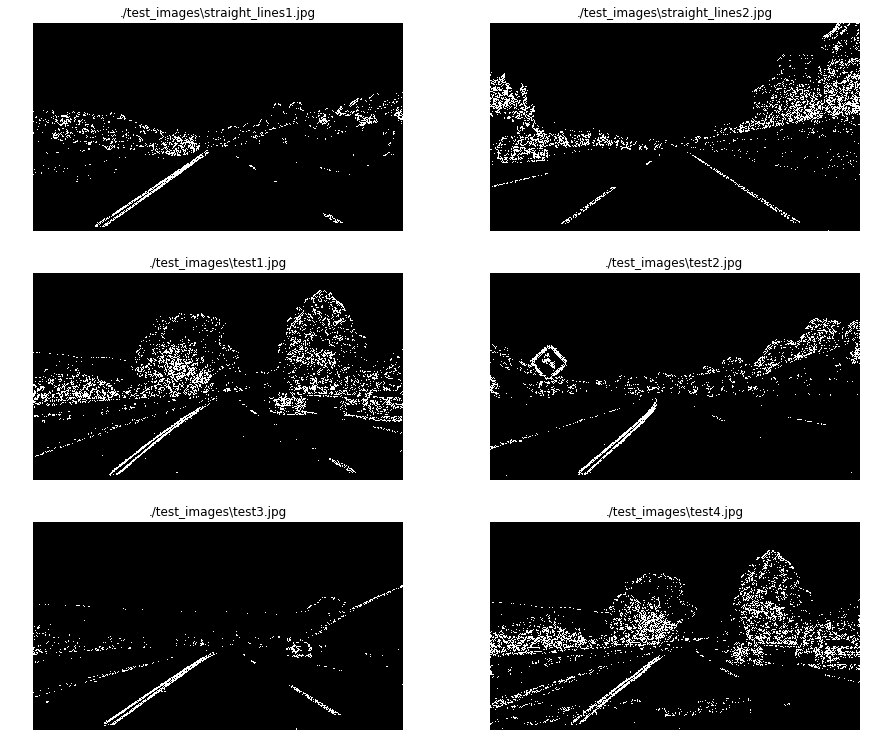

In [16]:
resultCombined = applyAndShow(testImages, combineGradients)

# Apply a perspective transform to rectify binary image ("birds-eye view").
the details about how the transformation matrix was calculated can be found [in this notebook](03-Perspective%20transformation.ipynb)

In [14]:
transMatrix = pickle.load( open('./pickled_data/perspective_transform.p', 'rb' ) )
M, Minv = map(transMatrix.get, ('M', 'Minv'))

In [15]:
def adjustPerspective(image, M=M):
    """
    Adjust the `image` using the transformation matrix `M`.
    """
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, img_size)
    return warped

combineAndTransform = lambda img: adjustPerspective(combineGradients(img))

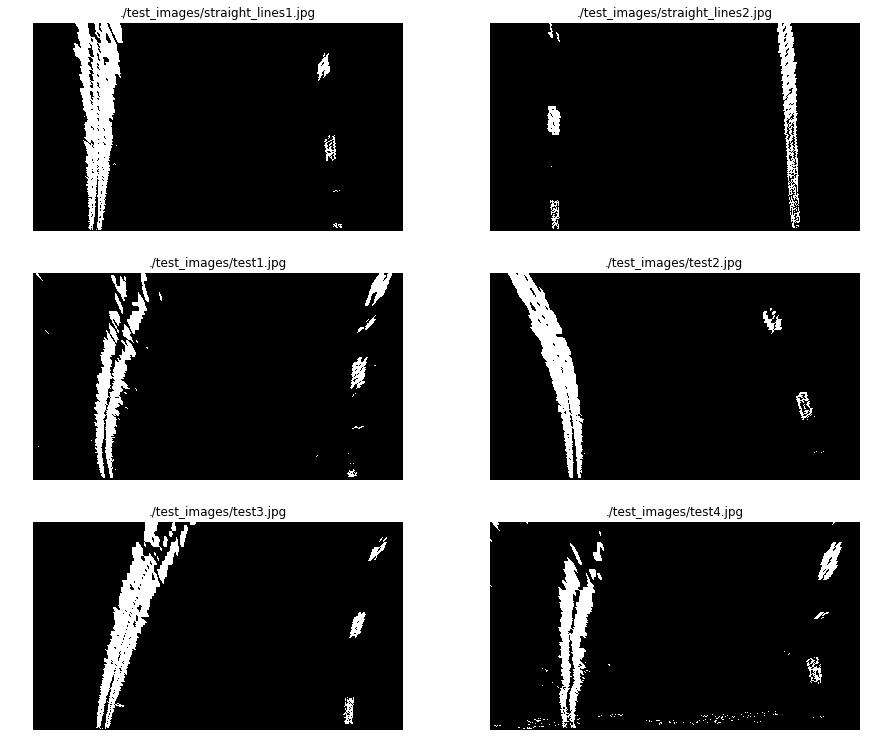

In [16]:
resultPerspective = applyAndShow(testImages, combineAndTransform, cmap='gray')


# Detect lane pixels and fit to find the lane boundary.

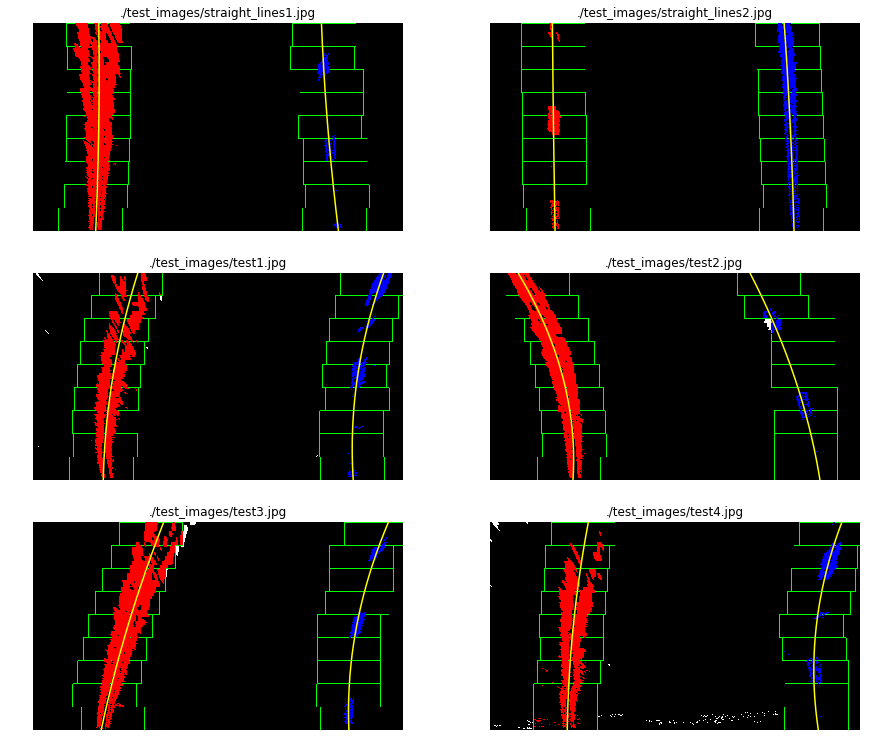

In [17]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def findLines(image, nwindows=9, margin=110, minpix=50):
    """
    Find the polynomial representation of the lines in the `image` using:
    - `nwindows` as the number of windows.
    - `margin` as the windows margin.
    - `minpix` as minimum number of pixes found to recenter the window.
    - `ym_per_pix` meters per pixel on Y.
    - `xm_per_pix` meters per pixels on X.
    
    Returns (left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)
    """    
    # Make a binary and transform image
    binary_warped = combineAndTransform(image)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)

def visualizeLanes(image, ax):
    """
    Visualize the windows and fitted lines for `image`.
    Returns (`left_fit` and `right_fit`)
    """
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = findLines(image)
    # Visualization
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ax.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    return ( left_fit, right_fit, left_fit_m, right_fit_m )

def showLaneOnImages(images, cols = 2, rows = 3, figsize=(15,13)):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    Returns a collection with the image paths and the left and right polynomials.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    imageAndFit = []
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            left_fit, right_fit, left_fit_m, right_fit_m = visualizeLanes(image, ax)
            ax.set_title(imagePathName)
            ax.axis('off')
            imageAndFit.append( ( imagePathName, left_fit, right_fit, left_fit_m, right_fit_m ) )
    return imageAndFit

imagesPoly = showLaneOnImages(testImages)

# Determine the curvature of the lane and vehicle position with respect to center.

In [18]:
def calculateCurvature(yRange, left_fit_cr):
    """
    Returns the curvature of the polynomial `fit` on the y range `yRange`.
    """
    
    return ((1 + (2*left_fit_cr[0]*yRange*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])

for imagePoly in imagesPoly:
    imagePath, left_fit, right_fit, left_fit_m, right_fit_m = imagePoly
    yRange = 719
    leftCurvature = calculateCurvature(yRange, left_fit_m) / 1000
    rightCurvature = calculateCurvature(yRange, right_fit_m) / 1000
    print('Image : {}, Left : {:.2f} km, Right : {:.2f} km'.format(imagePath, leftCurvature, rightCurvature))
    

Image : ./test_images/straight_lines1.jpg, Left : 4.07 km, Right : 2.83 km
Image : ./test_images/straight_lines2.jpg, Left : 23.32 km, Right : 5.12 km
Image : ./test_images/test1.jpg, Left : 0.80 km, Right : 0.56 km
Image : ./test_images/test2.jpg, Left : 0.36 km, Right : 0.66 km
Image : ./test_images/test3.jpg, Left : 1.33 km, Right : 0.51 km
Image : ./test_images/test4.jpg, Left : 1.35 km, Right : 0.45 km


# Warp the detected lane boundaries back onto the original image.

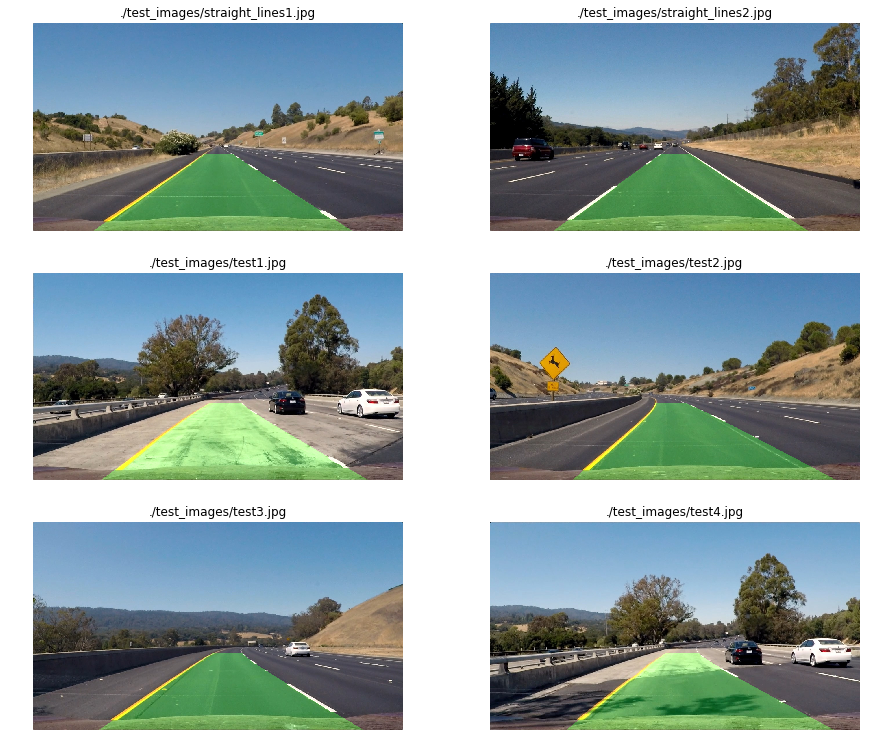

In [19]:
def drawLine(img, left_fit, right_fit):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

def drawLaneOnImage(img):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findLines(img)
    output = drawLine(img, left_fit, right_fit)
    return cv2.cvtColor( output, cv2.COLOR_BGR2RGB )

resultLines = applyAndShow(testImages, drawLaneOnImage)

# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

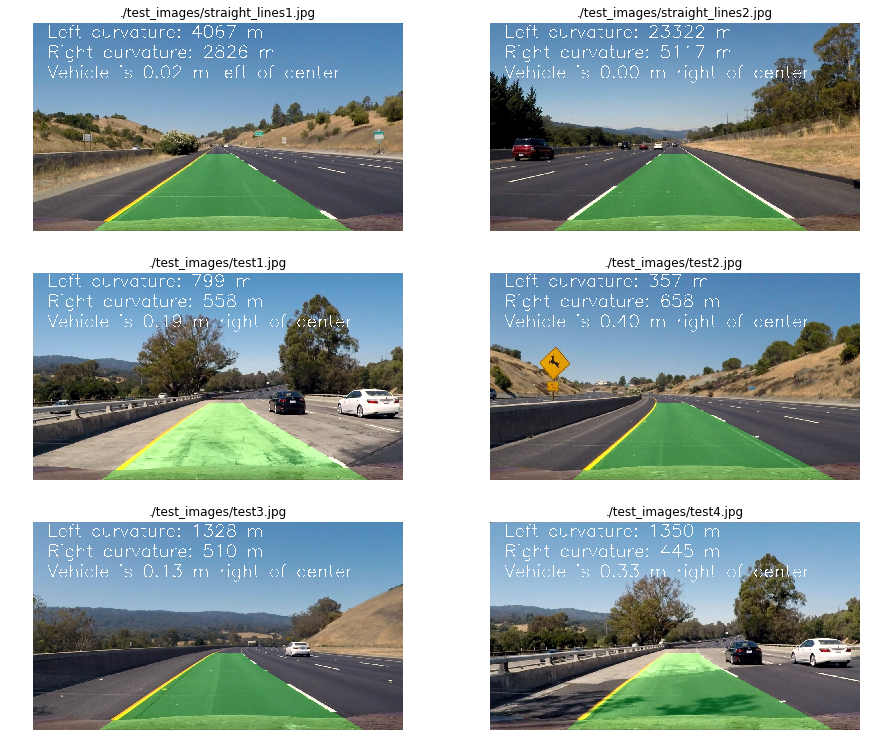

In [20]:
def pipeline(img, fontScale=2):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findLines(img)
    output = drawLine(img, left_fit, right_fit)
    
    # Calculate curvature
    leftCurvature = calculateCurvature(yRange, left_fit_m) 
    rightCurvature = calculateCurvature(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, fontScale, fontColor, 2)
    return output

resultDisplay = applyAndShow(testImages, lambda img: cv2.cvtColor(pipeline(img), cv2.COLOR_BGR2RGB ))

# Video pipeline

In [21]:
from moviepy.editor import VideoFileClip

class Lane():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.left_fit_m = None
        self.right_fit_m = None
        self.leftCurvature = None
        self.rightCurvature = None

def calculateLanes(img):
    """
    Calculates the lane on image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findLines(img)
    # Calculate curvature
    leftCurvature = calculateCurvature(yRange, left_fit_m) 
    rightCurvature = calculateCurvature(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle)

def displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle):
    """
    Display the lanes information on the image.
    """
    output = drawLine(img, left_fit, right_fit)
    
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, 1, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, 1, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, 1, fontColor, 2)
    return output
    
def videoPipeline(inputVideo, outputVideo):
    """
    Process the `inputVideo` frame by frame to find the lane lines, draw curvarute and vehicle position information and
    generate `outputVideo`
    """
    myclip = VideoFileClip(inputVideo)
    
    leftLane = Lane()
    rightLane = Lane()
    
    def processImage(img):
        left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle = calculateLanes(img)
        if leftCurvature > 10000:
            left_fit = leftLane.left_fit
            left_fit_m = leftLane.left_fit_m
            leftCurvature = leftLane.leftCurvature
        else:
            leftLane.left_fit = left_fit
            leftLane.left_fit_m = left_fit_m
            leftLane.leftCurvature = leftCurvature
        
        if rightCurvature > 10000:
            right_fit = rightLane.right_fit
            right_fit_m = rightLane.right_fit_m
            rightCurvature = rightLane.rightCurvature
        else:
            rightLane.right_fit = right_fit
            rightLane.right_fit_m = right_fit_m
            rightLane.rightCurvature = rightCurvature
            
        return displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle)

    clip = myclip.fl_image(processImage)
    clip.write_videofile(outputVideo, audio=False)

# Project video
videoPipeline('project_video.mp4', 'video_output/project_video.mp4')

[MoviePy] >>>> Building video video_output/project_video.mp4
[MoviePy] Writing video video_output/project_video.mp4


100%|█████████▉| 1260/1261 [03:37<00:00,  5.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/project_video.mp4 

